In [66]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [67]:
import numpy as np
import pandas as pd

In [68]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [91]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [92]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [93]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [94]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [95]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [96]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [97]:
#MAX DATE
max_date = session.query(func.max( Measurement.date)).limit(5).all()
max_date[0][0]


'2017-08-23'

# Exploratory Climate Analysis

In [98]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation score
precipitation_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data_df= pd.DataFrame(precipitation_data, columns=('date','precipitation'))
# Sort the dataframe by date
precipitation_data_df.set_index('date', inplace=True)
precipitation_data_df.sort_values(by='date')
precipitation_data_df.head(100)
# Use Pandas Plotting with Matplotlib to plot the data


,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2016-11-26,0.05
2016-11-27,0.00
2016-11-28,0.01


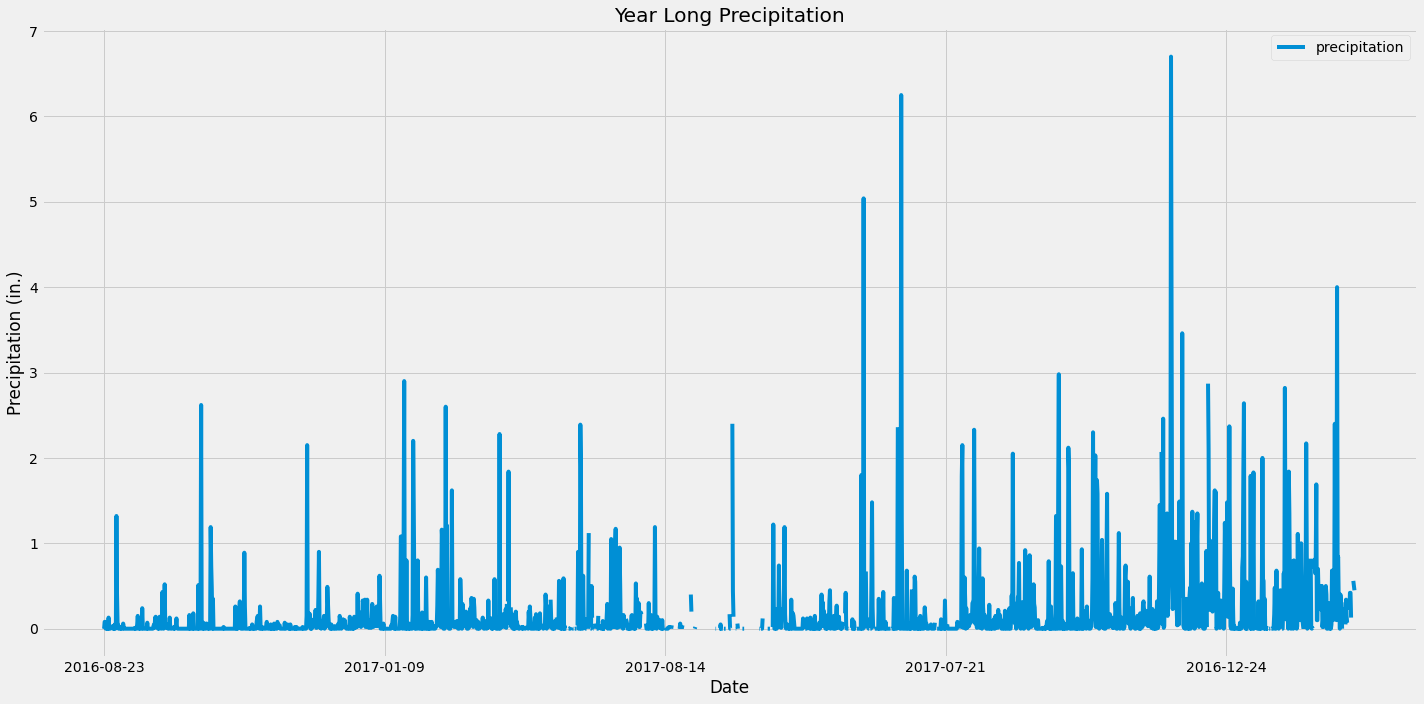

In [99]:
fig, ax = plt.subplots(figsize = (20, 10))
precipitation_data_df.plot(ax = ax, x_compat = True)

#title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Year Long Precipitation")

plt.savefig("Images/precipitation.png")

#plot
plt.tight_layout()
plt.show()

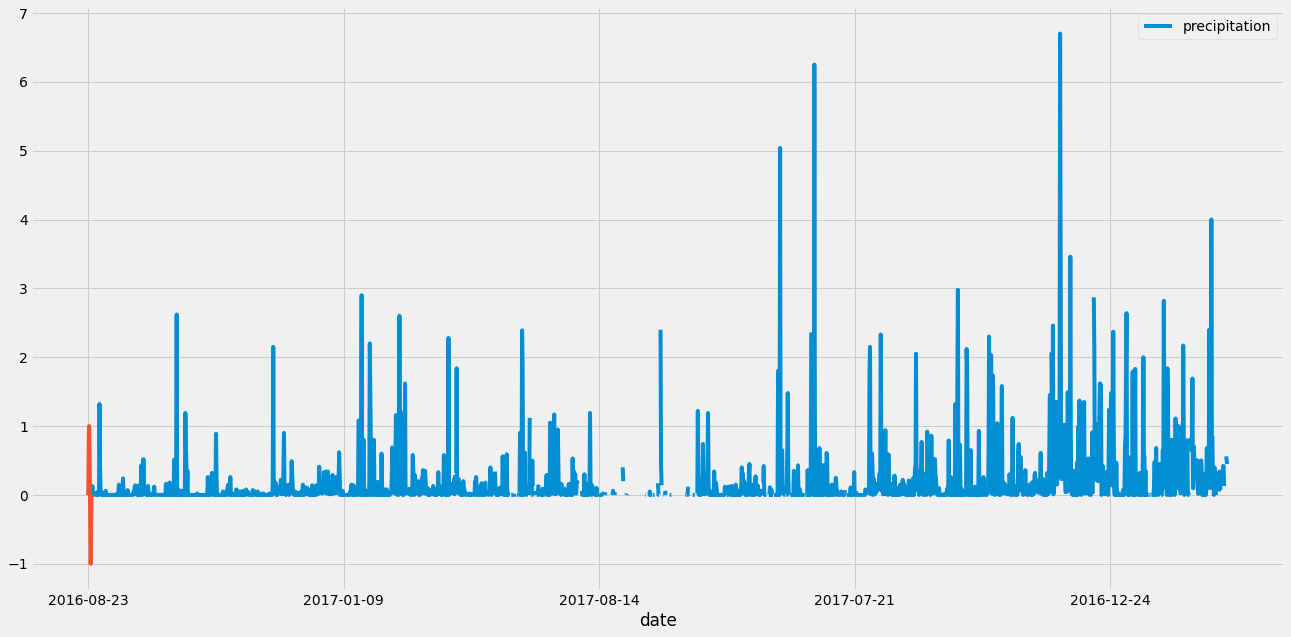

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation


fig, ax = plt.subplots(figsize = (20, 10))
precipitation_data_df.plot(ax = ax, x_compat = True)
x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def animate(i):
    line.set_ydata(np.sin(x + i / 50))  # update the data.
    return line,


ani = animation.FuncAnimation(
    fig, animate, interval=20, blit=True, save_count=50)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

plt.show()

In [101]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [102]:
precipitation_data_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [103]:
# Design a query to show how many stations are available in this dataset?
station_number= session.query(func.count( Station.station)).all()
station_number


[(9)]

In [104]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_station=session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [105]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station1=session.query(func.max(Measurement.tobs),func.min(Measurement.tobs),func.avg(Measurement.tobs)).filter_by(station='USC00519281').all()
most_active_station1

[(85.0, 54.0, 71.66378066378067)]

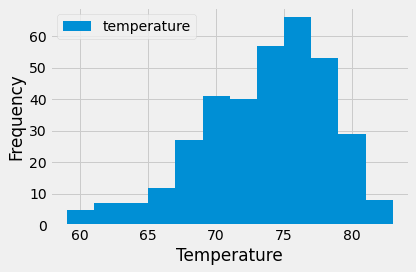

In [108]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observation = session.query(Measurement.date, Measurement.tobs).filter_by(station ='USC00519281').\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

#save as a data frame
temp_observation_df = pd.DataFrame(temp_observation, columns = ['date', 'temperature'])

fig, ax = plt.subplots()
temp_observation_df.plot.hist(bins = 12, ax = ax)

#labels
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')

#save figure
plt.savefig("Images/yearly_plot.png")

#plot
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
